In [1]:
#All necessary libraries are imported here, some weren't needed in the final edition but were used in the lifecycle
import pandas as pd
import seaborn as sns
import csv
import numpy as np
import sklearn
import pickle
import xgboost as xgb
from copy import deepcopy
from django.db.models import Model
from IPython.display import display
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from time import time
import pylab as plb
import matplotlib.pyplot as plt

#This path variable makes it easier to read CSV files in considering how many times it's done throughout the script
path = 'C:/Users/Admin/premier_predictions/Datasets/'
%matplotlib inline

In [7]:
#Almost 13 seasons of data is read in, all the way from 2007 to the last games that were played,
#as more games are played the 1920 file must be updated
data_season_1 = pd.read_csv(path + '0708.csv')
data_season_2 = pd.read_csv(path + '0809.csv')
data_season_3 = pd.read_csv(path + '0910.csv')
data_season_4 = pd.read_csv(path + '1011.csv')
data_season_5 = pd.read_csv(path + '1112.csv')
data_season_6 = pd.read_csv(path + '1213.csv')
data_season_7 = pd.read_csv(path + '1314.csv')
data_season_8 = pd.read_csv(path + '1415.csv')
data_season_9 = pd.read_csv(path + '1516.csv')
data_season_10 = pd.read_csv(path + '1617.csv')
data_season_11 = pd.read_csv(path + '1718.csv')
data_season_12 = pd.read_csv(path + '1819.csv')
#data_season_current = pd.read_csv(path + '1920.csv')

In [3]:
#When inputting dates into a model it won't read them in the format defined in the file, so once they are read into a df
#the format is change to something processable
data_season_1.Date = pd.to_datetime(data_season_1.Date, format='%d/%m/%Y')
data_season_2.Date = pd.to_datetime(data_season_2.Date, format='%d/%m/%Y')
data_season_3.Date = pd.to_datetime(data_season_3.Date, format='%d/%m/%Y')
data_season_4.Date = pd.to_datetime(data_season_4.Date, format='%d/%m/%Y')
data_season_5.Date = pd.to_datetime(data_season_5.Date, format='%d/%m/%Y')
data_season_6.Date = pd.to_datetime(data_season_6.Date, format='%d/%m/%Y')
data_season_7.Date = pd.to_datetime(data_season_7.Date, format='%d/%m/%Y')
data_season_8.Date = pd.to_datetime(data_season_8.Date, format='%d/%m/%Y')
data_season_9.Date = pd.to_datetime(data_season_9.Date, format='%d/%m/%Y')
data_season_10.Date = pd.to_datetime(data_season_10.Date, format='%d/%m/%Y')
data_season_11.Date = pd.to_datetime(data_season_11.Date, format='%d/%m/%Y')
data_season_12.Date = pd.to_datetime(data_season_12.Date, format='%d/%m/%Y')
data_season_current.Date = pd.to_datetime(data_season_current.Date, format='%d/%m/%Y')

In [8]:
#The columns are narrowed down to gameplay statistics, i.e. the basic data collected from a match
                      
gameplay_cols = ['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR']

#These columns are applied to each dataframe, this occurs a lot in the script as functions are created to make more detailed stats
data_season_1 = data_season_1[gameplay_cols]
data_season_2 = data_season_2[gameplay_cols]
data_season_3 = data_season_3[gameplay_cols]
data_season_4 = data_season_4[gameplay_cols]
data_season_5 = data_season_5[gameplay_cols]
data_season_6 = data_season_6[gameplay_cols]
data_season_7 = data_season_7[gameplay_cols]
data_season_8 = data_season_8[gameplay_cols]
data_season_9 = data_season_9[gameplay_cols]
data_season_10 = data_season_10[gameplay_cols]
data_season_11 = data_season_11[gameplay_cols]
data_season_12 = data_season_12[gameplay_cols]
#data_season_current = data_season_current[gameplay_cols]


In [9]:
#This function takes in a dataframe and aims to return the aggregate goals scored for a team
def total_goals_scored(data):
  #This teams dictionary separates each team by the HomeTeam variable so the function applies to each one uniquely
  teams = {key:[0] for key in data.HomeTeam.unique()}
  
  #The home team and away team's goals are added up according to matches in the past
  for i, row in data.iterrows():
    
    teams[row.HomeTeam].append(teams[row.HomeTeam][-1] + row.FTHG) 
    teams[row.AwayTeam].append(teams[row.AwayTeam][-1] + row.FTAG)
  
  #The total goals scored variable is created as empty and is then added to based on each match they played
  data['HTGS'] = 0
  data['ATGS'] = 0
  for i, row in data.iterrows():
    data.at[i, 'HTGS'] = teams[row.HomeTeam].pop(0)
    data.at[i, 'ATGS'] = teams[row.AwayTeam].pop(0)
  
  return data

#Function is applied to each season
data_season_1 = total_goals_scored(data_season_1)
data_season_2 = total_goals_scored(data_season_2)
data_season_3 = total_goals_scored(data_season_3)
data_season_4 = total_goals_scored(data_season_4)
data_season_5 = total_goals_scored(data_season_5)
data_season_6 = total_goals_scored(data_season_6)
data_season_7 = total_goals_scored(data_season_7)
data_season_8 = total_goals_scored(data_season_8)
data_season_9 = total_goals_scored(data_season_9)
data_season_10 = total_goals_scored(data_season_10)
data_season_11 = total_goals_scored(data_season_11)
data_season_12 = total_goals_scored(data_season_12)
#data_season_current = total_goals_scored(data_season_current)

In [11]:
#Same logic applies to getting the total goals conceded
def total_goals_conceded(data):
  teams = {key:[0] for key in data.HomeTeam.unique()}
  
  for i, row in data.iterrows():
    
    teams[row.HomeTeam].append(teams[row.HomeTeam][-1] + row.FTAG)
    teams[row.AwayTeam].append(teams[row.AwayTeam][-1] + row.FTHG)
  
  data['HTGC'] = 0
  data['ATGC'] = 0

  for i, row in data.iterrows():
    data.at[i, 'HTGC'] = teams[row.HomeTeam].pop(0)
    data.at[i, 'ATGC'] = teams[row.AwayTeam].pop(0)
  
  return data

data_season_1 = total_goals_conceded(data_season_1)
data_season_2 = total_goals_conceded(data_season_2)
data_season_3 = total_goals_conceded(data_season_3)
data_season_4 = total_goals_conceded(data_season_4)
data_season_5 = total_goals_conceded(data_season_5)
data_season_6 = total_goals_conceded(data_season_6)
data_season_7 = total_goals_conceded(data_season_7)
data_season_8 = total_goals_conceded(data_season_8)
data_season_9 = total_goals_conceded(data_season_9)
data_season_10 = total_goals_conceded(data_season_10)
data_season_11 = total_goals_conceded(data_season_11)
data_season_12 = total_goals_conceded(data_season_12)
#data_season_current = total_goals_conceded(data_season_current)


In [13]:
#Defining exactly what correlates a home win or away win
def match_points(is_home_team, FTR):
  if FTR == 'H':
    return 3 if is_home_team else 0
  elif FTR == 'A':
    return 0 if is_home_team else 3
  else:
    return 1

#Similar to getting the total goals, now that the results have been defined, we can get the total points per team
def total_points(data):
  teams = {key:[0] for key in data.HomeTeam.unique()}
  
  for i, row in data.iterrows():
    teams[row.HomeTeam].append(teams[row.HomeTeam][-1] + match_points(is_home_team=True, FTR=row.FTR))
    teams[row.AwayTeam].append(teams[row.AwayTeam][-1] + match_points(is_home_team=False, FTR=row.FTR))
    
  data['HTP'] = 0
  data['ATP'] = 0
  for i, row in data.iterrows():
    data.at[i, 'HTP'] = teams[row.HomeTeam].pop(0)
    data.at[i, 'ATP'] = teams[row.AwayTeam].pop(0)
  
  return data

data_season_1 = total_points(data_season_1)
data_season_2 = total_points(data_season_2)
data_season_3 = total_points(data_season_3)
data_season_4 = total_points(data_season_4)
data_season_5 = total_points(data_season_5)
data_season_6 = total_points(data_season_6)
data_season_7 = total_points(data_season_7)
data_season_8 = total_points(data_season_8)
data_season_9 = total_points(data_season_9)
data_season_10 = total_points(data_season_10)
data_season_11 = total_points(data_season_11)
data_season_12 = total_points(data_season_12)
#data_season_current = total_points(data_season_current)


In [14]:
#Defining what constitues a win (W), loss(L) or draw (D) for the home team in a match
def match_results(is_home_team, FTR):
  if FTR == 'H':
    return 'W' if is_home_team else 'L'
  elif FTR == 'A':
    return 'L' if is_home_team else 'W'
  else:
    return 'D'

def form_5_games(data):
  #The key in this dictionary is M as not enough matches have been played yet to build a run of form
  teams = {key:['M'] for key in data.HomeTeam.unique()}
  
  #similar to adding goals up, this loop will add each result on, so form and streaks can be monitored
  for i, row in data.iterrows():
    teams[row.HomeTeam].append(match_results(is_home_team=True, FTR=row.FTR))
    teams[row.AwayTeam].append(match_results(is_home_team=False, FTR=row.FTR))
    
  #using deepcopy to build up a run of form over 5 games
  teams2 = deepcopy(teams)
  teams3 = deepcopy(teams)
  teams4 = deepcopy(teams)
  teams5 = deepcopy(teams)   
  for key in teams:
    teams2[key].insert(0,'M')
    teams3[key].insert(0,'M')
    teams3[key].insert(0,'M')   
    teams4[key].insert(0,'M')
    teams4[key].insert(0,'M')
    teams4[key].insert(0,'M')    
    teams5[key].insert(0,'M')
    teams5[key].insert(0,'M')
    teams5[key].insert(0,'M')
    teams5[key].insert(0,'M')

  #Each teams first 5 games are defined as M as they haven't played them yet
  for i in range(1, 6):
    data['HM' + str(i)] = 'M'
    data['AM' + str(i)] = 'M'
  
  #The last 5 matches played by the home team and away team are added
  for i, row in data.iterrows():
    data.at[i, 'HM5'] = teams5[row.HomeTeam].pop(0)
    data.at[i, 'HM4'] = teams4[row.HomeTeam].pop(0)
    data.at[i, 'HM3'] = teams3[row.HomeTeam].pop(0)
    data.at[i, 'HM2'] = teams2[row.HomeTeam].pop(0)
    data.at[i, 'HM1'] = teams[row.HomeTeam].pop(0)
    
    data.at[i, 'AM5'] = teams5[row.AwayTeam].pop(0)
    data.at[i, 'AM4'] = teams4[row.AwayTeam].pop(0)
    data.at[i, 'AM3'] = teams3[row.AwayTeam].pop(0)
    data.at[i, 'AM2'] = teams2[row.AwayTeam].pop(0)
    data.at[i, 'AM1'] = teams[row.AwayTeam].pop(0)
  
  return data

data_season_1 = form_5_games(data_season_1)
data_season_2 = form_5_games(data_season_2)
data_season_3 = form_5_games(data_season_3)
data_season_4 = form_5_games(data_season_4)
data_season_5 = form_5_games(data_season_5)
data_season_6 = form_5_games(data_season_6)
data_season_7 = form_5_games(data_season_7)
data_season_8 = form_5_games(data_season_8)
data_season_9 = form_5_games(data_season_9)
data_season_10 = form_5_games(data_season_10)
data_season_11 = form_5_games(data_season_11)
data_season_12 = form_5_games(data_season_12)
#data_season_current = form_5_games(data_season_current)


In [16]:
new_cols = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 
        'FTAG', 'FTR', 'HTGS', 'ATGS', 'HTGC', 
        'ATGC', 'HTP', 'ATP',
        'HM1', 'HM2', 'HM3', 'HM4', 'HM5', 
        'AM1', 'AM2', 'AM3', 'AM4', 'AM5' ]

data_season_1 = data_season_1[new_cols]
data_season_2 = data_season_2[new_cols]
data_season_3 = data_season_3[new_cols]
data_season_4 = data_season_4[new_cols]
data_season_5 = data_season_5[new_cols]
data_season_6 = data_season_6[new_cols]
data_season_7 = data_season_7[new_cols]
data_season_8 = data_season_8[new_cols]
data_season_9 = data_season_9[new_cols]
data_season_10 = data_season_10[new_cols]
data_season_11 = data_season_11[new_cols]
data_season_12 = data_season_12[new_cols]
#data_season_current = data_season_current[new_cols]


In [17]:
#A file containing each teams previous league position back to 2006,
#if the team has just been promoted, their position from when they were last in the
#league and relegated is used.
prev_positions = pd.read_csv(path + "leaguepositions.csv")
prev_positions.set_index(['Team'], inplace=True)

#Luckily in 2019/20 each team had played in the league at least once since 2006,
#but this fills any year in which a new team starts the league as 18th
prev_positions = prev_positions.fillna(18)

#Given that every other season but the 2019/20 season has been completed,
#this will count only if 380 matches are played
def last_season_pos(data, prev_positions, year):
    HomeTeamLP = []
    AwayTeamLP = []
    for i in range(380):
        ht = data.iloc[i].HomeTeam
        at = data.iloc[i].AwayTeam
        HomeTeamLP.append(prev_positions.loc[ht][year])
        AwayTeamLP.append(prev_positions.loc[at][year])
    data['HomeTeamLP'] = HomeTeamLP
    data['AwayTeamLP'] = AwayTeamLP
    return data

#For the current year, at the time of execution, 288 matches have been played,
#the previous function wouldn't work so this would have to be updated as more matches are played
'''def most_recent_pos(data, prev_positions, year):
    HomeTeamLP = []
    AwayTeamLP = []
    for i in range(288):
        ht = data.iloc[i].HomeTeam
        at = data.iloc[i].AwayTeam
        HomeTeamLP.append(prev_positions.loc[ht][year])
        AwayTeamLP.append(prev_positions.loc[at][year])
    data['HomeTeamLP'] = HomeTeamLP
    data['AwayTeamLP'] = AwayTeamLP
    return data'''

data_season_1 = last_season_pos(data_season_1, prev_positions, 0)
data_season_2 = last_season_pos(data_season_2, prev_positions, 1)
data_season_3 = last_season_pos(data_season_3, prev_positions, 2)
data_season_4 = last_season_pos(data_season_4, prev_positions, 3)
data_season_5 = last_season_pos(data_season_5, prev_positions, 4)
data_season_6 = last_season_pos(data_season_6, prev_positions, 5)
data_season_7 = last_season_pos(data_season_7, prev_positions, 6)
data_season_8 = last_season_pos(data_season_8, prev_positions, 7)
data_season_9 = last_season_pos(data_season_9, prev_positions, 8)
data_season_10 = last_season_pos(data_season_10, prev_positions, 9)
data_season_11 = last_season_pos(data_season_11, prev_positions, 10)
data_season_12 = last_season_pos(data_season_12, prev_positions, 11)

#data_season_current = most_recent_pos(data_season_current, prev_positions, 12)

In [18]:
#The matchweek in which a certain game was played is calculated,
#this becomes important as with the first few matchweeks, 
#form can't really be checked.
def mw(data):
    j = 1
    MatchWeek = []
    for i in range(380):
        MatchWeek.append(j)
        if ((i + 1)% 10) == 0:
            j = j + 1
    data['MW'] = MatchWeek
    return data

'''def mw_19_20(data):
    j = 1
    MatchWeek = []
    for i in range(288):
        MatchWeek.append(j)
        if ((i + 1)% 10) == 0:
            j = j + 1
    data['MW'] = MatchWeek
    return data'''

data_season_1 = mw(data_season_1)
data_season_2 = mw(data_season_2)
data_season_3 = mw(data_season_3)
data_season_4 = mw(data_season_4)
data_season_5 = mw(data_season_5)
data_season_6 = mw(data_season_6)
data_season_7 = mw(data_season_7)
data_season_8 = mw(data_season_8)
data_season_9 = mw(data_season_9)
data_season_10 = mw(data_season_10)
data_season_11 = mw(data_season_11)
data_season_12 = mw(data_season_12)

#data_season_current = mw_19_20(data_season_current)

In [20]:
#Now that extra features have been calculated, each dataframe is added
#on top of each other to create one large dataframe for all matches that have
#been played since the beginning of 2007/08
all_seasons = pd.concat([data_season_1,
                         data_season_2,
                         data_season_3,
                         data_season_4,
                         data_season_5,
                         data_season_6,
                         data_season_8,
                         data_season_9,
                         data_season_10,
                         data_season_11,
                         data_season_12],  ignore_index=True, sort=False)
                         #data_season_current

#The last 5 matches for a team are put together as a string of 5 letters
all_seasons['HTFormPtsStr'] = all_seasons['HM1'] + all_seasons['HM2'] + all_seasons['HM3'] + all_seasons['HM4'] + all_seasons['HM5']
all_seasons['ATFormPtsStr'] = all_seasons['AM1'] + all_seasons['AM2'] + all_seasons['AM3'] + all_seasons['AM4'] + all_seasons['AM5']

#The points from the last 5 matches altogether are calculated and added to the dataframe
def generate_points(result):
  if result == 'W':
    return 3
  elif result == 'D':
    return 1
  else:
    return 0

def sum_points(form):
  sum = 0
  for f in form:
    sum += generate_points(f)
  return sum
  
def form_points(data):
  data['HTFormPts'] = None
  data['ATFormPts'] = None
  for i, row in data.iterrows():
    data.at[i, 'HTFormPts'] = sum_points(row.HTFormPtsStr)
    data.at[i, 'ATFormPts'] = sum_points(row.ATFormPtsStr)
  return data

all_seasons = form_points(all_seasons)

In [21]:
#Winning and losing streaks are defined to track form going into a match
def streaks(data):
  data['HTWinStreak3'] = 0
  data['HTWinStreak5'] = 0
  data['HTLossStreak3'] = 0
  data['HTLossStreak5'] = 0

  data['ATWinStreak3'] = 0
  data['ATWinStreak5'] = 0
  data['ATLossStreak3'] = 0
  data['ATLossStreak5'] = 0
  
  for i, row in data.iterrows():
    if 'WWW' in row.HTFormPtsStr:
      data.at[i, 'HTWinStreak3'] = 1
    if 'WWWWW' in row.HTFormPtsStr:
      data.at[i, 'HTWinStreak5'] = 1
    
    if 'WWW' in row.ATFormPtsStr:
      data.at[i, 'ATWinStreak3'] = 1
    if 'WWWWW' in row.ATFormPtsStr:
      data.at[i, 'ATWinStreak5'] = 1
      
    if 'LLL' in row.HTFormPtsStr:
      data.at[i, 'HTLossStreak3'] = 1
    if 'LLLLL' in row.HTFormPtsStr:
      data.at[i, 'HTLossStreak5'] = 1
      
    if 'LLL' in row.ATFormPtsStr:
      data.at[i, 'ATLossStreak3'] = 1
    if 'LLLLL' in row.ATFormPtsStr:
      data.at[i, 'ATLossStreak5'] = 1
    
  return data

all_seasons = streaks(all_seasons)

In [22]:
#Using the goals scored, the goal difference for a team
#can be calculated, which is a valuable statistic
all_seasons['HTGD'] = all_seasons['HTGS'] - all_seasons['HTGC']
all_seasons['ATGD'] = all_seasons['ATGS'] - all_seasons['ATGC']

#The difference in points between two teams can show the gulf in class
#between them and makes it easier to predict who will win.
all_seasons['DiffPts'] = all_seasons['HTP'] - all_seasons['ATP']

#The difference in points over the last few games is also valuable as a
#team could be having a poor season, but could have won their last 5 matches
all_seasons['DiffFormPts'] = all_seasons['HTFormPts'] - all_seasons['ATFormPts']

#The difference in league position from the previous year also gives an indication
#of who would be likely to win
all_seasons['DiffLP'] = all_seasons['HomeTeamLP'] - all_seasons['AwayTeamLP']


In [23]:
#Every column is added and the dataframe is ready to be exported
all_cols = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTGS', 'ATGS',
       'HTGC', 'ATGC', 'HTP', 'ATP', 'HM1', 'HM2', 'HM3', 'HM4', 'HM5', 'AM1',
       'AM2', 'AM3', 'AM4', 'AM5', 'HomeTeamLP', 'AwayTeamLP', 'MW',
       'HTFormPtsStr', 'ATFormPtsStr', 'HTFormPts', 'ATFormPts',
       'HTWinStreak3', 'HTWinStreak5', 'HTLossStreak3', 'HTLossStreak5',
       'ATWinStreak3', 'ATWinStreak5', 'ATLossStreak3', 'ATLossStreak5',
       'HTGD', 'ATGD', 'DiffPts', 'DiffFormPts', 'DiffLP']



all_seasons = all_seasons[all_cols]

In [24]:
all_seasons.to_csv(path + 'full_dataset2.csv')

In [25]:
#This stage prepares the data for an algorithm
original_data = pd.read_csv(path + 'full_dataset.csv')

#The first 3 games for each team isn't taken into account as they haven't
#built up a streak of form yet
original_data = original_data[original_data.MW > 3]

#For easier reading, each of these irrelevant columns are dropped
original_data.drop(['Unnamed: 0','HomeTeam', 'AwayTeam', 'Date', 'MW', 'HTFormPtsStr', 'ATFormPtsStr', 'FTHG', 'FTAG',
           'HTGS', 'ATGS', 'HTGC', 'ATGC','HomeTeamLP', 'AwayTeamLP','DiffPts','HTFormPts','ATFormPts',
           'HM4','HM5','AM4','AM5','HTLossStreak5','ATLossStreak5','HTWinStreak5','ATWinStreak5',
           'HTWinStreak3','HTLossStreak3','ATWinStreak3','ATLossStreak3'],1, inplace=True)
original_data.head()

,FTR,HTP,ATP,HM1,HM2,HM3,AM1,AM2,AM3,HTGD,ATGD,DiffFormPts,DiffLP
30,H,7,5,D,W,W,W,D,D,2,2,2,-16.0
31,A,1,1,L,L,D,L,D,L,-5,-2,0,0.0
32,D,6,4,L,W,W,D,W,M,2,1,2,5.0
33,A,4,4,L,D,W,D,W,M,-2,1,0,17.0
34,D,3,6,W,L,M,W,W,L,-1,3,-3,-1.0


In [6]:
#Basic statistic trends across the 13 years are calculated to give an
#idea of how the data is spread
number_of_matches = original_data.shape[0]

number_of_homewins = len(original_data[original_data.FTR == 'H'])
number_of_awaywins = len(original_data[original_data.FTR == 'A'])
number_of_draws = len(original_data[original_data.FTR == 'D'])

homewin_rate = (float(number_of_homewins) / (number_of_matches)) * 100
awaywin_rate = (float(number_of_awaywins) / (number_of_matches)) * 100
draw_rate = (float(number_of_draws) / (number_of_matches)) * 100

print ("Total number of matches: {}".format(number_of_matches))

print ("Number of matches won by home team: {}".format(number_of_homewins))
print ("Number of matches won by away team: {}".format(number_of_awaywins))
print ("Number of matches drawn: {}".format(number_of_draws))

print ("Win rate of home team: {:.2f}%".format(homewin_rate))
print ("Win rate of away team: {:.2f}%".format(awaywin_rate))
print ("Draw rate: {:.2f}%".format(draw_rate))


Total number of matches: 4108
Number of matches won by home team: 1910
Number of matches won by away team: 1159
Number of matches drawn: 1039
Win rate of home team: 46.49%
Win rate of away team: 28.21%
Draw rate: 25.29%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013CE7704518>,
      dtype=object)

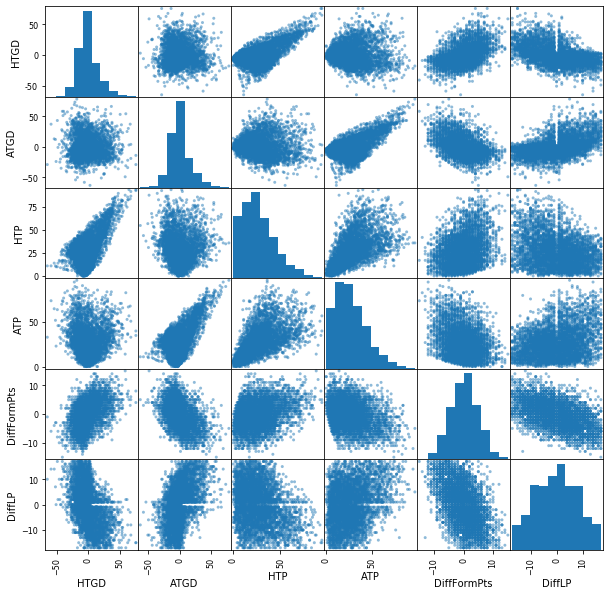

In [442]:
scatter_matrix(original_data[['HTGD','ATGD','HTP','ATP','DiffFormPts','DiffLP']], figsize=(10,10))

In [26]:
#The dataset has to be split in order to isolate the target, which is FTR
x_set = original_data.drop(['FTR'],1)
y_set = original_data['FTR']

#Previously set up features are added to x_set to aid the prediction
needed_cols = [['HTGD','ATGD','HTP','ATP','DiffLP']]
for col in needed_cols:
    x_set[col] = scale(x_set[col])
#The sets data types are checked before preprocessing to avoid errors
x_set.dtypes

HTP            float64
ATP            float64
HM1             object
HM2             object
HM3             object
AM1             object
AM2             object
AM3             object
HTGD           float64
ATGD           float64
DiffFormPts      int64
DiffLP         float64
dtype: object

In [27]:
#Each match used in a streak is changed so it can be preprocessed properly
x_set.HM1 = x_set.HM1.astype('str')
x_set.HM2 = x_set.HM2.astype('str')
x_set.HM3 = x_set.HM3.astype('str')
x_set.AM1 = x_set.AM1.astype('str')
x_set.AM2 = x_set.AM2.astype('str')
x_set.AM3 = x_set.AM3.astype('str')

def preprocessing(x):
    output = pd.DataFrame(index = x.index)
    
    #Each object is changed to an integer
    for col, col_data in x.iteritems():
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
        output = output.join(col_data)
    return output

x_set = preprocessing(x_set)
#These two columns are dropped as they are irrelevant, we want to see the results only
x_set = x_set.drop(['HM3_M', 'AM3_M'],1)

#This statement confirms that the relevant columns were preprocessed
print ("({} total features)\n{}".format(len(x_set.columns), list(x_set.columns)))

(24 total features)
['HTP', 'ATP', 'HM1_D', 'HM1_L', 'HM1_W', 'HM2_D', 'HM2_L', 'HM2_W', 'HM3_D', 'HM3_L', 'HM3_W', 'AM1_D', 'AM1_L', 'AM1_W', 'AM2_D', 'AM2_L', 'AM2_W', 'AM3_D', 'AM3_L', 'AM3_W', 'HTGD', 'ATGD', 'DiffFormPts', 'DiffLP']


In [28]:
#Double checking the new data types
x_set.dtypes

HTP            float64
ATP            float64
HM1_D            uint8
HM1_L            uint8
HM1_W            uint8
HM2_D            uint8
HM2_L            uint8
HM2_W            uint8
HM3_D            uint8
HM3_L            uint8
HM3_W            uint8
AM1_D            uint8
AM1_L            uint8
AM1_W            uint8
AM2_D            uint8
AM2_L            uint8
AM2_W            uint8
AM3_D            uint8
AM3_L            uint8
AM3_W            uint8
HTGD           float64
ATGD           float64
DiffFormPts      int64
DiffLP         float64
dtype: object

In [29]:
#Both sets are split into training and test sets
#The last 50 games are used as a test and not randomised
x_train, x_test, y_train, y_test = train_test_split(x_set, y_set,
                                                    test_size = 50,
                                                    shuffle = False)


In [30]:
#These are the fixtures to be tested
x_test

,HTP,ATP,HM1_D,HM1_L,HM1_W,HM2_D,HM2_L,HM2_W,HM3_D,HM3_L,...,AM2_D,AM2_L,AM2_W,AM3_D,AM3_L,AM3_W,HTGD,ATGD,DiffFormPts,DiffLP
4418,0.407770,2.122966,0,0,1,1,0,0,0,1,...,0,0,1,0,0,1,0.256522,2.327272,-8,1.645142
4419,-0.224459,2.295855,0,1,0,1,0,0,0,1,...,0,0,1,0,0,1,-0.666617,2.388856,-11,1.058835
4420,1.212425,0.739856,0,0,1,0,1,0,0,1,...,0,1,0,0,0,1,1.733545,0.541346,1,0.472528
4421,-0.224459,-0.124588,0,0,1,0,1,0,0,1,...,1,0,0,0,1,0,-0.851244,-0.875079,-4,-0.700086
4422,0.177869,0.336449,0,1,0,1,0,0,1,0,...,1,0,0,0,0,1,-0.358904,0.110260,0,-0.817348
4423,2.476884,0.221189,0,0,1,0,0,1,0,0,...,0,1,0,0,0,1,2.533599,-0.690328,5,-1.520916
4424,0.177869,-0.585625,1,0,0,0,0,1,1,0,...,0,0,1,0,1,0,-0.728159,-1.429332,0,-0.934609
4425,-0.224459,0.163560,0,1,0,1,0,0,0,0,...,1,0,0,0,0,1,-0.912787,-0.443993,2,0.707051
4426,-0.224459,-0.124588,0,1,0,0,1,0,1,0,...,1,0,0,0,1,0,-0.789702,-0.443993,-1,-0.231040
4427,0.407770,0.394078,0,1,0,0,1,0,0,0,...,0,0,1,1,0,0,0.441150,0.171844,2,-1.872700


In [31]:
#These functions will determine which is the quickest, and most accurate
#model on both the training set and test set
def classifier_training(clf, x_train, y_train):
    start = time()
    clf.fit(x_train, y_train)
    end = time()
    
    print ("Takes {:.4f} seconds to train".format(end - start))
    
def labels_prediction(clf, features, target):
    start = time()
    y_prediction = clf.predict(features)
    end = time()
    
    print ("Takes {:.4f} seconds to predict".format(end - start))
    
    return f1_score(target, y_prediction, pos_label='H', average='micro'), sum(target == y_prediction) / float(len(y_prediction))

def train_predictor(clf, x_train, y_train, x_test, y_test):
    print ("Model used: {}".format(clf.__class__.__name__))
    
    classifier_training(clf, x_train, y_train)
    
    f1, acc = labels_prediction(clf, x_train, y_train)
    print (f1, acc)
    print ("F1 and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = labels_prediction(clf, x_test, y_test)
    print ("F1 and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))
    

In [32]:
#Each model is taken from scikit-learn and applied accordingly
#as one code block to directly compare
dectree = tree.DecisionTreeClassifier(criterion='entropy')
supvec = SVC(random_state = 912, kernel = 'rbf', gamma = 'scale')
lr = LogisticRegression(random_state = 42)
xgboost = xgb.XGBClassifier(seed = 82)

train_predictor(dectree, x_train, y_train, x_test, y_test)
print ('')
train_predictor(supvec, x_train, y_train, x_test, y_test)
print ('')
train_predictor(lr, x_train, y_train, x_test, y_test)
print ('')
train_predictor(xgboost, x_train, y_train, x_test, y_test)
print ('')

Model used: DecisionTreeClassifier
Takes 0.1170 seconds to train
Takes 0.0040 seconds to predict
1.0

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1259: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1259: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


 1.0
F1 and accuracy score for training set: 1.0000 , 1.0000.
Takes 0.0020 seconds to predict
F1 and accuracy score for test set: 0.4800 , 0.4800.

Model used: SVC
Takes 4.2601 seconds to train
Takes 1.0453 seconds to predict
0.5411532774765895 0.5411532774765895
F1 and accuracy score for training set: 0.5412 , 0.5412.
Takes 0.0100 seconds to predict
F1 and accuracy score for test set: 0.5400 , 0.5400.

Model used: LogisticRegression
Takes 0.0691 seconds to train
Takes 0.0099 seconds to predict
0.5384425825529817 0.5384425825529817
F1 and accuracy score for training set: 0.5384 , 0.5384.
Takes 0.0010 seconds to predict
F1 and accuracy score for test set: 0.5200 , 0.5200.

Model used: XGBClassifier


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1259: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1259: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning

Takes 6.0275 seconds to train
Takes 0.1310 seconds to predict
0.9618038442582554 0.9618038442582553
F1 and accuracy score for training set: 0.9618 , 0.9618.
Takes 0.0770 seconds to predict
F1 and accuracy score for test set: 0.5000 , 0.5000.



In [1031]:
#While the accuracy across all 4 isn't the best, the most ideal
#given its performance on the training set is XGBoost.
#By tuning the hyperparameters correctly, an increase in accuracy is possible
parameters = { 'learning_rate' : [0.15],
               'max_depth': [5],
               'min_child_weight': [5],
               'gamma':[0.0],
               'colsample_bytree' : [0.3],
             }

clf = xgb.XGBClassifier(seed=2)

f1_measure = make_scorer(f1_score,pos_label='H',average='micro')

grid = GridSearchCV(clf,
                    scoring=f1_measure,
                    param_grid=parameters,
                    cv=5)

grid = grid.fit(x_train,y_train)

clf = grid.best_estimator_
print (clf)

f1, acc = labels_prediction(clf, x_train, y_train)
print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))

f1, acc = labels_prediction(clf, x_test, y_test)
print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1259: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.15, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=2, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=2, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)
Made predictions in 0.0690 seconds.
F1 score and accuracy score for training set: 0.6730 , 0.6730.
Made predictions in 0.0030 seconds.
F1 score and accuracy score for test set: 0.6000 , 0.6000.


In [1032]:
#This checks out whether the 60% accuracy is true on the test set
#by printing its predictions
clf.predict(x_test)


array(['H', 'H', 'H', 'H', 'H', 'H', 'A', 'H', 'D', 'H'], dtype=object)

In [1073]:
#Now the same process must be repeated for the next 10 matches
pred_data = pd.read_csv(path + 'next_matches.csv')

In [1074]:
pred_data.head()

,HomeTeam,AwayTeam,FTR
0,Arsenal,Liverpool,NaN
1,Burnley,Wolves,NaN
2,Chelsea,Norwich,NaN
3,Crystal Palace,Man United,NaN
4,Everton,Aston Villa,NaN


In [1075]:
cols = ['FTHG', 'FTAG', 'HTGS', 'ATGS',
       'HTGC', 'ATGC', 'HTP', 'ATP', 'HM1', 'HM2', 'HM3', 'HM4', 'HM5', 'AM1',
       'AM2', 'AM3', 'AM4', 'AM5',
       'HTWinStreak3', 'HTWinStreak5', 'HTLossStreak3',
       'HTLossStreak5', 'ATWinStreak3', 'ATWinStreak5', 'ATLossStreak3',
       'ATLossStreak5', 'HTGD', 'ATGD', 'DiffPts', 'DiffFormPts', 'DiffLP']

pred_data = pred_data.join(pd.DataFrame(columns=cols))

In [1077]:
pred_data.dtypes

HomeTeam          object
AwayTeam          object
FTR              float64
FTHG              object
FTAG              object
HTGS              object
ATGS              object
HTGC              object
ATGC              object
HTP               object
ATP               object
HM1               object
HM2               object
HM3               object
HM4               object
HM5               object
AM1               object
AM2               object
AM3               object
AM4               object
AM5               object
HTWinStreak3      object
HTWinStreak5      object
HTLossStreak3     object
HTLossStreak5     object
ATWinStreak3      object
ATWinStreak5      object
ATLossStreak3     object
ATLossStreak5     object
HTGD              object
ATGD              object
DiffPts           object
DiffFormPts       object
DiffLP            object
dtype: object

In [1078]:
#The full dataset is taken in again as the columns need to be
#copied over
df = pd.read_csv(path + 'full_dataset.csv')

In [1079]:
df.columns

Index(['Unnamed: 0', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTGS', 'ATGS', 'HTGC', 'ATGC', 'HTP', 'ATP', 'HM1', 'HM2', 'HM3',
       'HM4', 'HM5', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5', 'HomeTeamLP',
       'AwayTeamLP', 'MW', 'HTFormPtsStr', 'ATFormPtsStr', 'HTFormPts',
       'ATFormPts', 'HTWinStreak3', 'HTWinStreak5', 'HTLossStreak3',
       'HTLossStreak5', 'ATWinStreak3', 'ATWinStreak5', 'ATLossStreak3',
       'ATLossStreak5', 'HTGD', 'ATGD', 'DiffPts', 'DiffFormPts', 'DiffLP'],
      dtype='object')

In [1080]:
df = df.drop(['Unnamed: 0'], axis=1)

In [1081]:
df.shape

(4468, 42)

In [1082]:
#Each feature is copied over for both the home team and away team
for i, row in pred_data.iterrows():
  data_temp = df.copy()
  data_temp = df[(data_temp.HomeTeam == row.HomeTeam) | (data_temp.AwayTeam == row.HomeTeam)]
  temp_row = data_temp.iloc[-1]
  
  pred_data.at[i, 'HTGS'] = temp_row.HTGS
  pred_data.at[i, 'HTGC'] = temp_row.HTGC
  pred_data.at[i, 'HTP'] = temp_row.HTP
  
  pred_data.at[i, 'HM1'] = temp_row.HM1
  pred_data.at[i, 'HM2'] = temp_row.HM2
  pred_data.at[i, 'HM3'] = temp_row.HM3
  pred_data.at[i, 'HM4'] = temp_row.HM4
  pred_data.at[i, 'HM5'] = temp_row.HM5
  
  pred_data.at[i, 'HTWinStreak3'] = temp_row.HTWinStreak3
  pred_data.at[i, 'HTWinStreak5'] = temp_row.HTWinStreak5
  pred_data.at[i, 'HTLossStreak3'] = temp_row.HTLossStreak3
  pred_data.at[i, 'HTLossStreak5'] = temp_row.HTLossStreak5
  
  pred_data.at[i, 'HTGD'] = temp_row.HTGD

  data_temp = df.copy()
  data_temp = data_temp[(data_temp.HomeTeam == row.AwayTeam) | (data_temp.AwayTeam == row.AwayTeam)]
  temp_row = data_temp.iloc[-1]
  
  pred_data.at[i, 'ATGS'] = temp_row.ATGS
  pred_data.at[i, 'ATGC'] = temp_row.ATGC
  pred_data.at[i, 'ATP'] = temp_row.ATP
  
  pred_data.at[i, 'AM1'] = temp_row.AM1
  pred_data.at[i, 'AM2'] = temp_row.AM2
  pred_data.at[i, 'AM3'] = temp_row.AM3
  pred_data.at[i, 'AM4'] = temp_row.AM4
  pred_data.at[i, 'AM5'] = temp_row.AM5
  
  pred_data.at[i, 'ATWinStreak3'] = temp_row.ATWinStreak3
  pred_data.at[i, 'ATWinStreak5'] = temp_row.ATWinStreak5
  pred_data.at[i, 'ATLossStreak3'] = temp_row.ATLossStreak3
  pred_data.at[i, 'ATLossStreak5'] = temp_row.ATLossStreak5
  
  pred_data.at[i, 'ATGD'] = temp_row.ATGD
  
  
  #Each difference feature needs to be redefined
  pred_data['DiffPts'] = pred_data['HTP'] - pred_data['ATP']

In [1083]:
pred_data.columns

Index(['HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG', 'HTGS', 'ATGS', 'HTGC',
       'ATGC', 'HTP', 'ATP', 'HM1', 'HM2', 'HM3', 'HM4', 'HM5', 'AM1', 'AM2',
       'AM3', 'AM4', 'AM5', 'HTWinStreak3', 'HTWinStreak5', 'HTLossStreak3',
       'HTLossStreak5', 'ATWinStreak3', 'ATWinStreak5', 'ATLossStreak3',
       'ATLossStreak5', 'HTGD', 'ATGD', 'DiffPts', 'DiffFormPts', 'DiffLP'],
      dtype='object')

In [1084]:
pred_data['HTFormPtsStr'] = pred_data['HM1'] + pred_data['HM2'] + pred_data['HM3'] + pred_data['HM4'] + pred_data['HM5']
pred_data['ATFormPtsStr'] = pred_data['AM1'] + pred_data['AM2'] + pred_data['AM3'] + pred_data['AM4'] + pred_data['AM5']

def change_result_to_points(result):
  if result == 'W':
    return 3
  elif result == 'D':
    return 1
  else:
    return 0

def total_form_points(form):
  sum = 0
  for f in form:
    sum += change_result_to_points(f)
  return sum
  
def form_points(df):
  
  df['HTFormPts'] = None
  df['ATFormPts'] = None
  for i, row in df.iterrows():
    df.at[i, 'HTFormPts'] = total_form_points(row.HTFormPtsStr)
    df.at[i, 'ATFormPts'] = total_form_points(row.ATFormPtsStr)
  
  return df

pred_data = form_points(pred_data)

In [1085]:
pred_data = pred_data.drop(['HTFormPtsStr', 'ATFormPtsStr'], axis=1)

In [1086]:
pred_data['DiffFormPts'] = pred_data['HTFormPts'] - pred_data['ATFormPts']

In [1087]:
#This was initially being passed over as an object, and had to be changed
pred_data.DiffFormPts = pred_data.DiffFormPts.astype('int')

In [1088]:
pred_data.dtypes

HomeTeam          object
AwayTeam          object
FTR              float64
FTHG              object
FTAG              object
HTGS              object
ATGS              object
HTGC              object
ATGC              object
HTP               object
ATP               object
HM1               object
HM2               object
HM3               object
HM4               object
HM5               object
AM1               object
AM2               object
AM3               object
AM4               object
AM5               object
HTWinStreak3      object
HTWinStreak5      object
HTLossStreak3     object
HTLossStreak5     object
ATWinStreak3      object
ATWinStreak5      object
ATLossStreak3     object
ATLossStreak5     object
HTGD              object
ATGD              object
DiffPts           object
DiffFormPts        int32
DiffLP            object
HTFormPts         object
ATFormPts         object
dtype: object

In [1089]:
current_pos = pd.read_csv(path + "current_table.csv")
current_pos.set_index(['Team'], inplace=True)
current_pos = current_pos.fillna(18)

def present_pos(df, current_pos, year):
    HomeTeamLP = []
    AwayTeamLP = []
    for i in range(10):
        ht = df.iloc[i].HomeTeam
        at = df.iloc[i].AwayTeam
        HomeTeamLP.append(current_pos.loc[ht][year])
        AwayTeamLP.append(current_pos.loc[at][year])
    df['HomeTeamLP'] = HomeTeamLP
    df['AwayTeamLP'] = AwayTeamLP
    return df

pred_data = present_pos(pred_data, current_pos, 0)
pred_data['DiffLP'] = pred_data['HomeTeamLP'] - pred_data['AwayTeamLP']

In [1090]:
pred_data.dtypes

HomeTeam          object
AwayTeam          object
FTR              float64
FTHG              object
FTAG              object
HTGS              object
ATGS              object
HTGC              object
ATGC              object
HTP               object
ATP               object
HM1               object
HM2               object
HM3               object
HM4               object
HM5               object
AM1               object
AM2               object
AM3               object
AM4               object
AM5               object
HTWinStreak3      object
HTWinStreak5      object
HTLossStreak3     object
HTLossStreak5     object
ATWinStreak3      object
ATWinStreak5      object
ATLossStreak3     object
ATLossStreak5     object
HTGD              object
ATGD              object
DiffPts           object
DiffFormPts        int32
DiffLP             int64
HTFormPts         object
ATFormPts         object
HomeTeamLP         int64
AwayTeamLP         int64
dtype: object

In [1092]:
pred_data.drop(['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG',
           'HTGS', 'ATGS', 'HTGC', 'ATGC','HomeTeamLP', 'AwayTeamLP','DiffPts','HTFormPts','ATFormPts',
           'HM4','HM5','AM4','AM5','HTLossStreak5','ATLossStreak5','HTWinStreak5','ATWinStreak5',
           'HTWinStreak3','HTLossStreak3','ATWinStreak3','ATLossStreak3'],1, inplace=True)

In [1093]:
x_predset = pred_data.drop(['FTR'],1)
y_predset = pred_data['FTR']


needed_cols = [['HTGD','ATGD','HTP','ATP','DiffLP']]
for col in needed_cols:
    x_predset[col] = scale(x_predset[col])
x_predset

,HTP,ATP,HM1,HM2,HM3,AM1,AM2,AM3,HTGD,ATGD,DiffFormPts,DiffLP
0,-0.545363,-0.302399,W,W,D,D,L,L,0.120854,-0.433989,2,1.244643
1,-0.350590,-0.204851,D,W,W,L,D,D,-0.604269,0.054249,8,0.756548
2,1.012816,-0.887689,D,W,L,W,L,L,0.523700,-0.922226,2,-1.683929
3,-0.740135,2.624047,W,W,L,W,W,L,-0.684838,2.603931,-4,1.000595
4,1.012816,-0.497496,D,W,L,L,L,L,0.523700,-0.488237,2,-0.585714
5,1.986678,-0.887689,L,L,D,W,L,L,1.973946,-0.922226,1,-0.219643
6,0.428499,-0.302399,D,W,W,D,L,L,0.845977,-0.433989,1,-1.683929
7,-1.129680,0.965727,L,W,L,L,L,W,-1.409961,0.867977,-3,0.878572
8,-1.129680,-0.204851,L,W,L,L,D,D,-1.409961,0.054249,3,0.146429
9,-0.545363,-0.302399,W,W,D,W,L,D,0.120854,-0.379740,5,0.146429


In [1094]:
x_predset.HM1 = x_predset.HM1.astype('str')
x_predset.HM2 = x_predset.HM2.astype('str')
x_predset.HM3 = x_predset.HM3.astype('str')
#x_predset.HM4 = x_predset.HM4.astype('str')
#x_predset.HM5 = x_predset.HM5.astype('str')

x_predset.AM1 = x_predset.AM1.astype('str')
x_predset.AM2 = x_predset.AM2.astype('str')
x_predset.AM3 = x_predset.AM3.astype('str')
#x_predset.AM4 = x_predset.AM4.astype('str')
#x_predset.AM5 = x_predset.AM5.astype('str')

#x_predset.FTR = x_predset.FTR.astype('str')
y_predset

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: FTR, dtype: float64

In [1095]:
def pred_preprocessing(x):
    output = pd.DataFrame(index = x.index)
    
    for col, col_data in x.iteritems():
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
        output = output.join(col_data)
    return output

x_predset = pred_preprocessing(x_predset)
print ("Processed feature columns ({} total features):\n{}".format(len(x_predset.columns), list(x_predset.columns)))

Processed feature columns (23 total features):
['HTP', 'ATP', 'HM1_D', 'HM1_L', 'HM1_W', 'HM2_L', 'HM2_W', 'HM3_D', 'HM3_L', 'HM3_W', 'AM1_D', 'AM1_L', 'AM1_W', 'AM2_D', 'AM2_L', 'AM2_W', 'AM3_D', 'AM3_L', 'AM3_W', 'HTGD', 'ATGD', 'DiffFormPts', 'DiffLP']


In [1096]:
#In this rare case, none of the home teams had a draw in the 2 match
#in the string, so it must be inputted as such for the model to work properly
HM2_D = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
x_predset.insert(5, 'HM2_D', HM2_D)
x_predset.columns

Index(['HTP', 'ATP', 'HM1_D', 'HM1_L', 'HM1_W', 'HM2_D', 'HM2_L', 'HM2_W',
       'HM3_D', 'HM3_L', 'HM3_W', 'AM1_D', 'AM1_L', 'AM1_W', 'AM2_D', 'AM2_L',
       'AM2_W', 'AM3_D', 'AM3_L', 'AM3_W', 'HTGD', 'ATGD', 'DiffFormPts',
       'DiffLP'],
      dtype='object')

In [1097]:
#Double checking this sets columns and contents before passing it
x_predset

,HTP,ATP,HM1_D,HM1_L,HM1_W,HM2_D,HM2_L,HM2_W,HM3_D,HM3_L,...,AM2_D,AM2_L,AM2_W,AM3_D,AM3_L,AM3_W,HTGD,ATGD,DiffFormPts,DiffLP
0,-0.545363,-0.302399,0,0,1,0,0,1,1,0,...,0,1,0,0,1,0,0.120854,-0.433989,2,1.244643
1,-0.350590,-0.204851,1,0,0,0,0,1,0,0,...,1,0,0,1,0,0,-0.604269,0.054249,8,0.756548
2,1.012816,-0.887689,1,0,0,0,0,1,0,1,...,0,1,0,0,1,0,0.523700,-0.922226,2,-1.683929
3,-0.740135,2.624047,0,0,1,0,0,1,0,1,...,0,0,1,0,1,0,-0.684838,2.603931,-4,1.000595
4,1.012816,-0.497496,1,0,0,0,0,1,0,1,...,0,1,0,0,1,0,0.523700,-0.488237,2,-0.585714
5,1.986678,-0.887689,0,1,0,0,1,0,1,0,...,0,1,0,0,1,0,1.973946,-0.922226,1,-0.219643
6,0.428499,-0.302399,1,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0.845977,-0.433989,1,-1.683929
7,-1.129680,0.965727,0,1,0,0,0,1,0,1,...,0,1,0,0,0,1,-1.409961,0.867977,-3,0.878572
8,-1.129680,-0.204851,0,1,0,0,0,1,0,1,...,1,0,0,1,0,0,-1.409961,0.054249,3,0.146429
9,-0.545363,-0.302399,0,0,1,0,0,1,1,0,...,0,1,0,1,0,0,0.120854,-0.379740,5,0.146429


In [1098]:
#Given the accuracy of when the hyperparameters were tuned, they must
#be done the same way
parameters = { 'learning_rate' : [0.15],
               'max_depth': [5],
               'min_child_weight': [5],
               'gamma':[0.0],
               'colsample_bytree' : [0.3],
             }

clf = xgb.XGBClassifier(seed=2)

f1_measure = make_scorer(f1_score,pos_label='H',average='micro')

grid = GridSearchCV(clf,
                    scoring=f1_measure,
                    param_grid=parameters,
                    cv=5)

#The previous sets are fitted as they will act as a standard to be met for
#all predictions. Splits and training and tests sets are no longer needed
grid = grid.fit(x_set,y_set)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1259: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


In [1099]:
clf = grid.best_estimator_

In [1100]:
#The next round of matches are predicted
predictions = clf.predict(x_predset)
predictions

array(['A', 'H', 'H', 'A', 'H', 'H', 'H', 'A', 'A', 'H'], dtype=object)

In [1102]:
#The results are given as an array, and must be changed back to a 
#dataframe so they can be printed to a CSV file
y_predset = pd.DataFrame(predictions)


,0
0,A
1,H
2,H
3,A
4,H
5,H
6,H
7,A
8,A
9,H


In [1130]:
#The fixture list is re-read and the results are added to the FTR column
upcoming_matches = pd.read_csv(path +'next_matches.csv')
next_predictions = upcoming_matches.join(y_predset)
next_games_preds = next_predictions.drop(['FTR'],1).rename(columns={0: "PRED"})


In [1132]:
next_games_preds.to_csv(path + 'gw30predictions.csv')